In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from torchvision import models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import pickle

In [2]:
os.getcwd()

'c:\\Users\\LENEVO SC\\Aditya\\CV Projects\\FaceDetection'

In [3]:
folders = []
for folder in os.listdir("./Output/"):
    if os.path.isdir(os.path.join("./Output/",folder)):
        folders.append(folder)

In [4]:
folders

['Aditya',
 'Amma',
 'Anu Doddamma',
 'Aprana Doddamma',
 'Chinna Mama',
 'Chinni Akka',
 'Hrishikesh Peddananna',
 'Krishna Tatagaru',
 'Lakshmi nannamma',
 'Nanna',
 'Others',
 'Padma Doddamma',
 'Padma Pinni',
 'Ramakrishna Guruvu garu',
 'Ravi Mama',
 'Shyam Bava',
 'Srinivas Peddananna',
 'Test',
 'Ujwal',
 'Usha Atta',
 'Usha Doddamma',
 'Vasantha atta']

In [5]:
folders.remove("Test")
folders.remove("Others")

In [6]:
train_dir = os.path.join('.', 'train')
val_dir = os.path.join('.', 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [7]:
for folder in folders:
    folder_path = os.path.join('./Output/', folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    
    # Create corresponding subdirectories in train and val directories
    train_subdir = os.path.join(train_dir, folder)
    val_subdir = os.path.join(val_dir, folder)
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(val_subdir, exist_ok=True)
    
    train_images, val_images = train_test_split(images, train_size=0.8, random_state=31)
    
    for img in train_images:
        src = os.path.join(folder_path, img)
        dst = os.path.join(train_subdir, img)
        shutil.copy(src, dst)
    
    for img in val_images:
        src = os.path.join(folder_path, img)
        dst = os.path.join(val_subdir, img)
        shutil.copy(src, dst)


In [8]:

# Define the transformation to convert the images to tensors
to_tensor_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create a dataset with the to_tensor transformation
dataset = datasets.ImageFolder(root='./train/', transform=to_tensor_transforms)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [9]:


# Check for CUDA availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the mean and std variables
mean = torch.zeros(3).to(device)  # 3 for number of channels in the image (RGB)
std = torch.zeros(3).to(device)
nb_samples = 0.

# Loop over the dataset to calculate the mean and std
for data, _ in data_loader:
    data = data.to(device)  # Move the data to the GPU
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

# Finalize the calculation of mean and std
mean /= nb_samples
std /= nb_samples

# Move the calculated mean and std back to the CPU if you want to print or use them outside GPU
mean = mean.to("cpu").numpy()
std = std.to("cpu").numpy()

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: [0.54503673 0.37135038 0.32368606]
Standard Deviation: [0.18558799 0.14716423 0.1355178 ]


In [3]:


train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.54503673, 0.37135038, 0.32368606], [0.18558799, 0.14716423, 0.1355178]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.54503673, 0.37135038, 0.32368606], [0.18558799, 0.14716423, 0.1355178]),
])


In [4]:


train_dataset = ImageFolder(root='./train/', transform=train_transforms)
val_dataset = ImageFolder(root='./val/', transform=val_transforms)


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


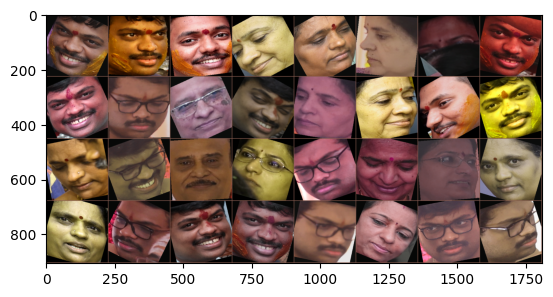

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5414491, 0.36814964, 0.31905356])
    std = np.array([0.18634783, 0.14681968, 0.1354009 ])
    inp = std * inp + mean  # Denormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)


In [10]:
class_names = train_dataset.class_to_idx
print(class_names)


{'Aditya': 0, 'Amma': 1, 'Anu Doddamma': 2, 'Aprana Doddamma': 3, 'Chinna Mama': 4, 'Chinni Akka': 5, 'Hrishikesh Peddananna': 6, 'Krishna Tatagaru': 7, 'Lakshmi nannamma': 8, 'Nanna': 9, 'Padma Doddamma': 10, 'Padma Pinni': 11, 'Ramakrishna Guruvu garu': 12, 'Ravi Mama': 13, 'Shyam Bava': 14, 'Srinivas Peddananna': 15, 'Ujwal': 16, 'Usha Atta': 17, 'Usha Doddamma': 18, 'Vasantha atta': 19}


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
device

device(type='cuda')

## Custom Model 1

In [21]:
class CustomFaceModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomFaceModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [batch_size, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [batch_size, 64, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # [batch_size, 128, 28, 28]
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


training with  param 0.001 - 32
Epoch 1/20, Train Acc: 0.2878, Val Acc: 0.3769
Validation loss decreased (inf --> 2045.799321). Saving model ...
Epoch 2/20, Train Acc: 0.4538, Val Acc: 0.4923
Validation loss decreased (2045.799321 --> 943.447091). Saving model ...
Epoch 3/20, Train Acc: 0.4790, Val Acc: 0.5154
Validation loss decreased (943.447091 --> 847.030997). Saving model ...
Epoch 4/20, Train Acc: 0.5714, Val Acc: 0.5385
Validation loss decreased (847.030997 --> 706.627850). Saving model ...
Epoch 5/20, Train Acc: 0.6113, Val Acc: 0.5308
Validation loss decreased (706.627850 --> 626.077565). Saving model ...
Epoch 6/20, Train Acc: 0.6744, Val Acc: 0.6308
Validation loss decreased (626.077565 --> 521.251464). Saving model ...
Epoch 7/20, Train Acc: 0.7122, Val Acc: 0.6538
Validation loss decreased (521.251464 --> 462.627842). Saving model ...
Epoch 8/20, Train Acc: 0.7521, Val Acc: 0.6538
Validation loss decreased (462.627842 --> 388.197778). Saving model ...
Epoch 9/20, Train Acc

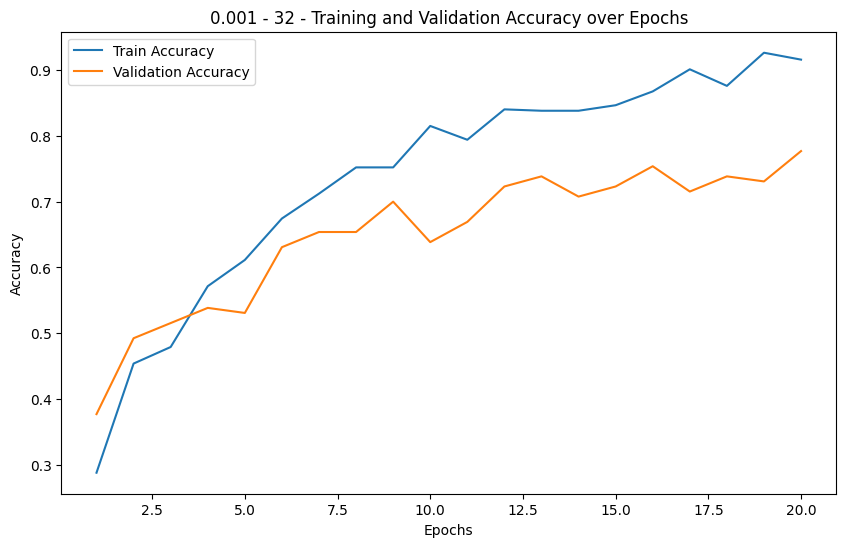

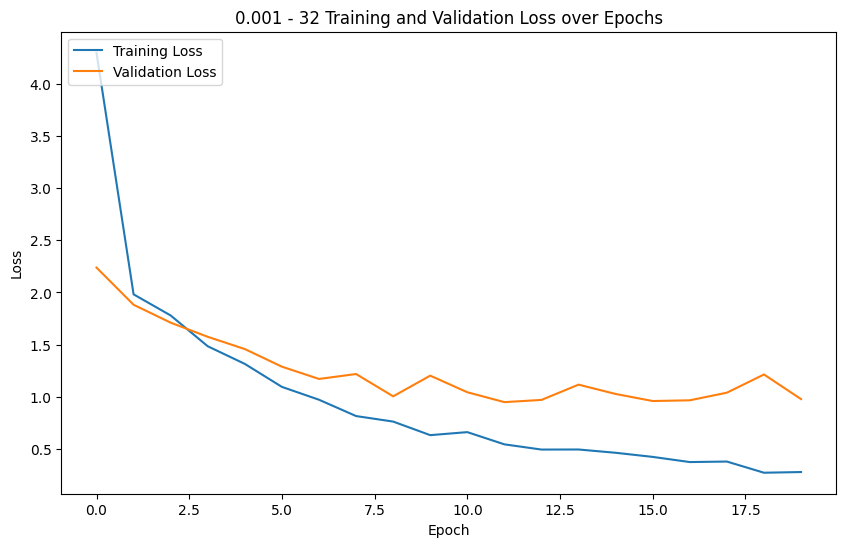

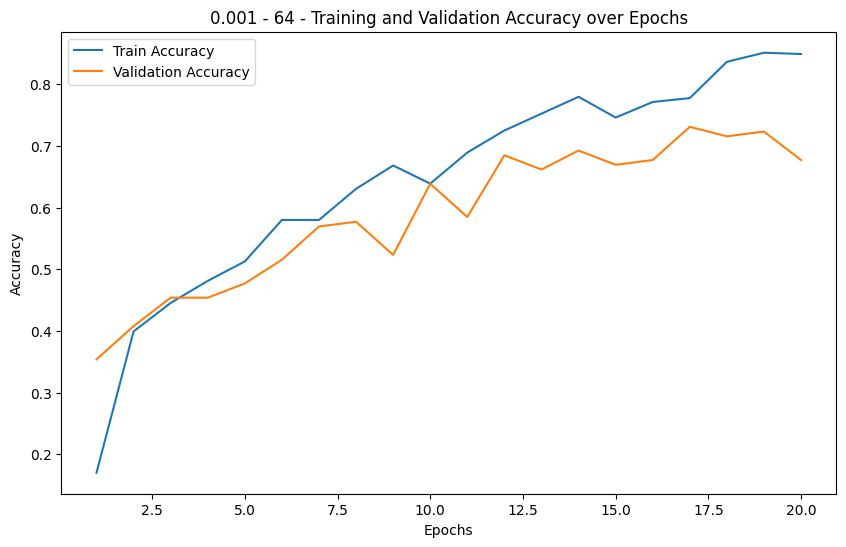

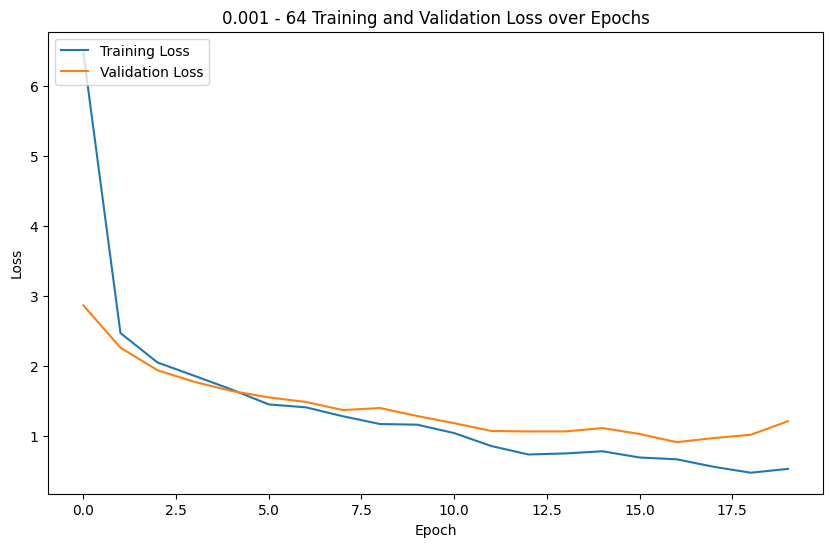

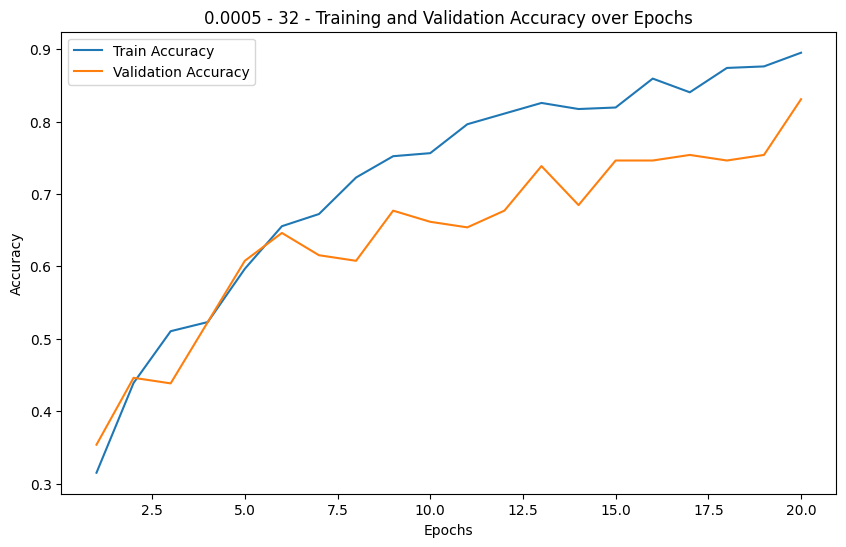

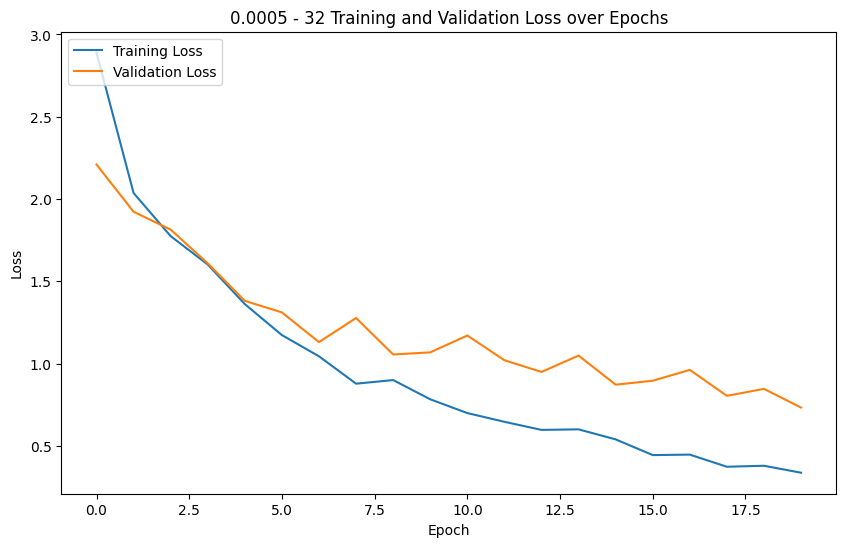

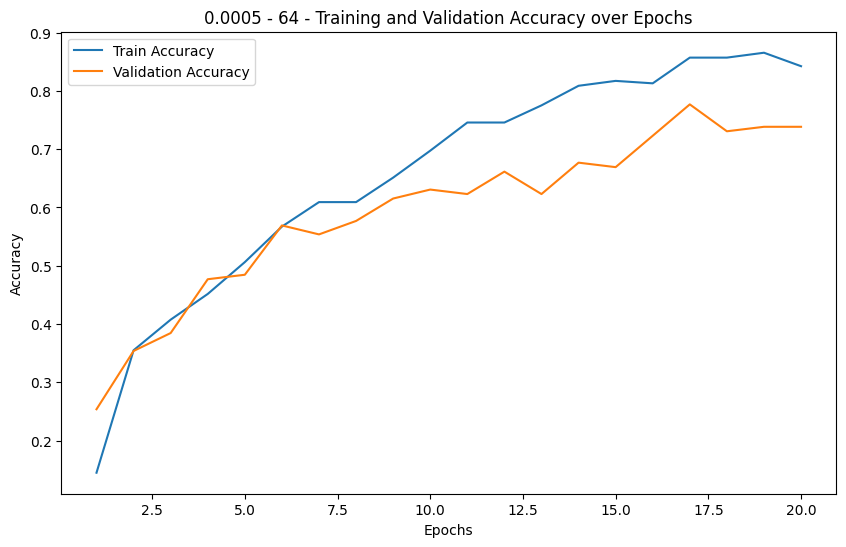

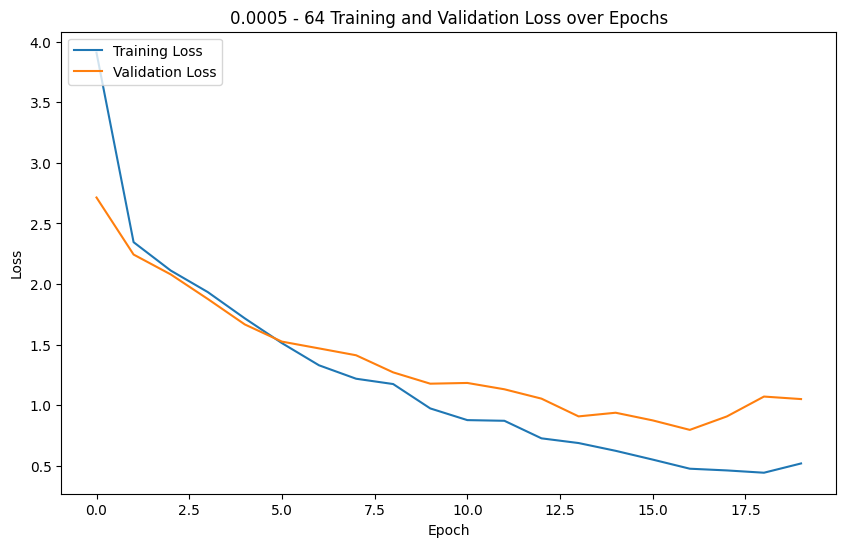

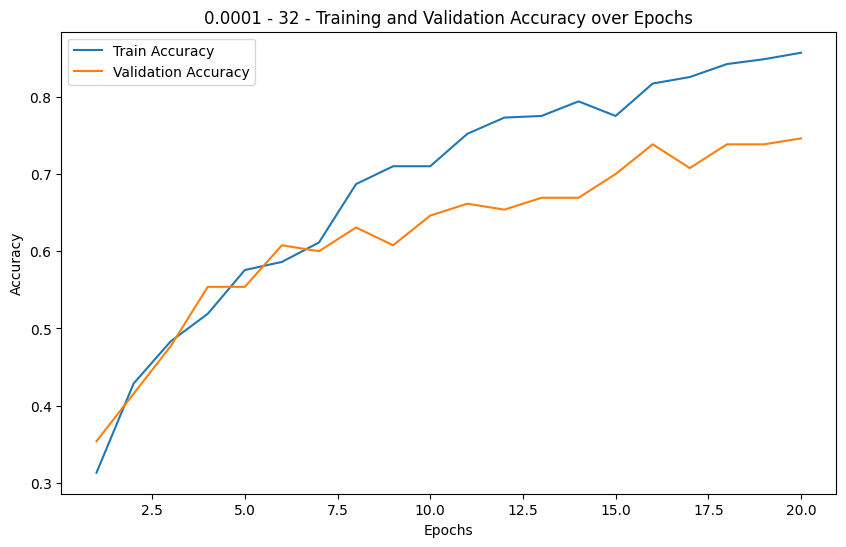

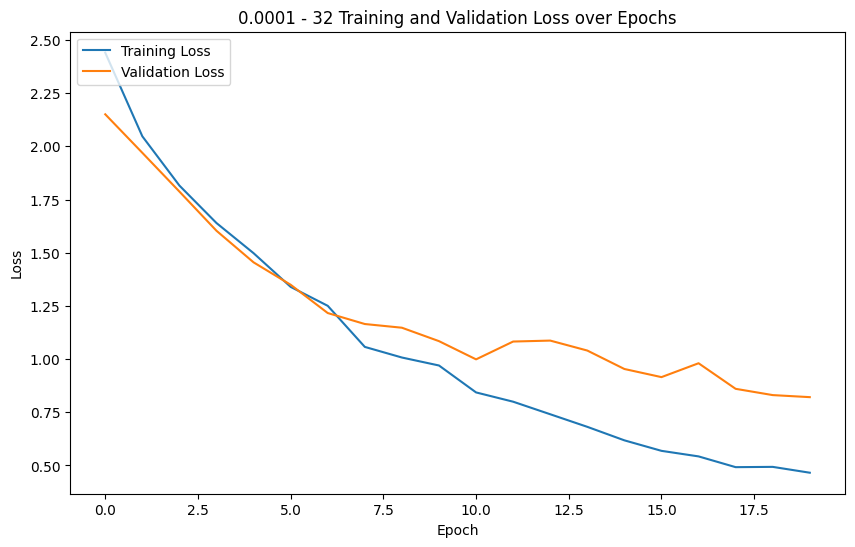

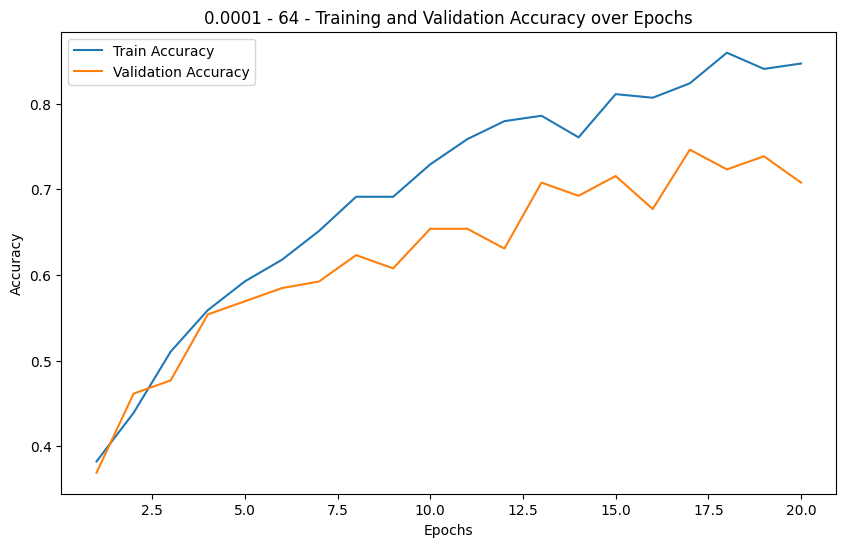

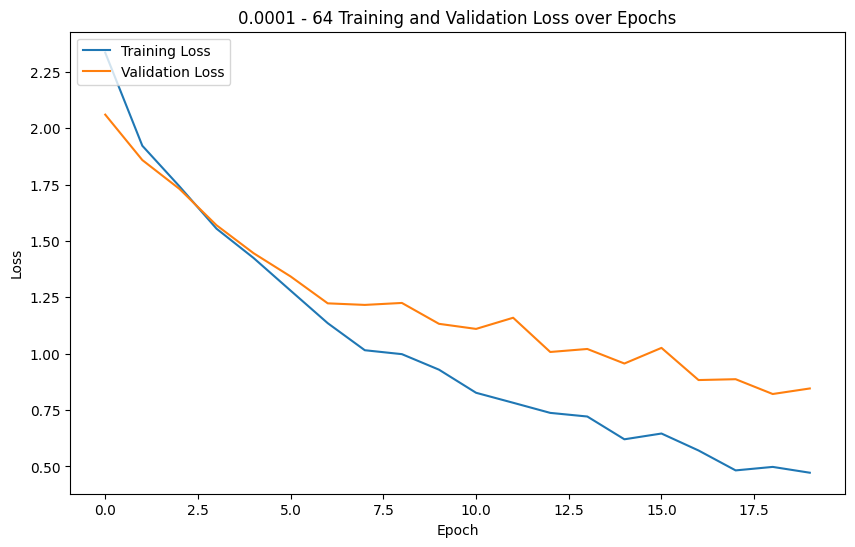

In [30]:
# Define hyperparameter search space
learning_rates = [0.001,0.0005,0.0001]
batch_sizes = [32, 64]
train_accuracies = []
val_accuracies = []
num_classes = 20
num_epochs = 20
# Hyperparameter tuning loop
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"training with  param {lr} - {bs}")
        # Initialize model, criterion, optimizer, and early stopping
        model = CustomFaceModel(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        early_stopping = EarlyStopping(patience=5, verbose=True)
        
        # Update DataLoader with new batch size
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        
        # Training loop with early stopping
        # Lists to store accuracies
        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []
        
        # Training Loop with early stopping
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            running_corrects = 0
            val_loss = 0.0
            val_corrects = 0
            # Training Step
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
            
            # Calculate Training Accuracy
            epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
            train_accuracies.append(epoch_train_acc.cpu().detach().numpy())
            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)
            
            # Validation Step
            model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
            # Calculate Validation Accuracy
            epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
            val_accuracies.append(epoch_val_acc.cpu().detach().numpy())
            
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")
            
            # Early Stopping
            early_stopping(running_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        
        torch.save(model,f"{lr} - {bs}.pkl")
        
        plt.figure(figsize=(10,6))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')

        plt.title(f'{lr} - {bs} - Training and Validation Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
            
        # Save the plot as an image file before showing it
        plt.savefig(f"{lr} - {bs}_accuracy_plot.png")
        
        plt.figure(figsize=(10,6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{lr} - {bs} Training and Validation Loss over Epochs')
        plt.legend(loc='upper left')
        plt.savefig(f"{lr} - {bs}_loss_plot.png")

* Observation:

    1. Model is overfitting

## Pre-Trained Models

In [33]:
model_names = ['mobilenet_v2', 'vgg16','resnet50' ]

Training mobilenet_v2...


c:\Users\LENEVO SC\Aditya\CV Projects\FaceDetection\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\LENEVO SC/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 4.95MB/s]


Epoch 1/20, Train Acc: 0.5252, Val Acc: 0.5462
Validation loss decreased (inf --> 1.806878). Saving model ...
Epoch 2/20, Train Acc: 0.7542, Val Acc: 0.7462
Validation loss decreased (1.806878 --> 0.901599). Saving model ...
Epoch 3/20, Train Acc: 0.8950, Val Acc: 0.7615
Validation loss decreased (0.901599 --> 0.876003). Saving model ...
Epoch 4/20, Train Acc: 0.9223, Val Acc: 0.8615
Validation loss decreased (0.876003 --> 0.439877). Saving model ...
Epoch 5/20, Train Acc: 0.9433, Val Acc: 0.8462
EarlyStopping counter: 1 out of 5
Epoch 6/20, Train Acc: 0.9685, Val Acc: 0.9077
Validation loss decreased (0.439877 --> 0.277428). Saving model ...
Epoch 7/20, Train Acc: 0.9769, Val Acc: 0.9077
Validation loss decreased (0.277428 --> 0.259614). Saving model ...
Epoch 8/20, Train Acc: 0.9811, Val Acc: 0.9385
Validation loss decreased (0.259614 --> 0.237956). Saving model ...
Epoch 9/20, Train Acc: 0.9895, Val Acc: 0.8846
EarlyStopping counter: 1 out of 5
Epoch 10/20, Train Acc: 0.9832, Val Ac

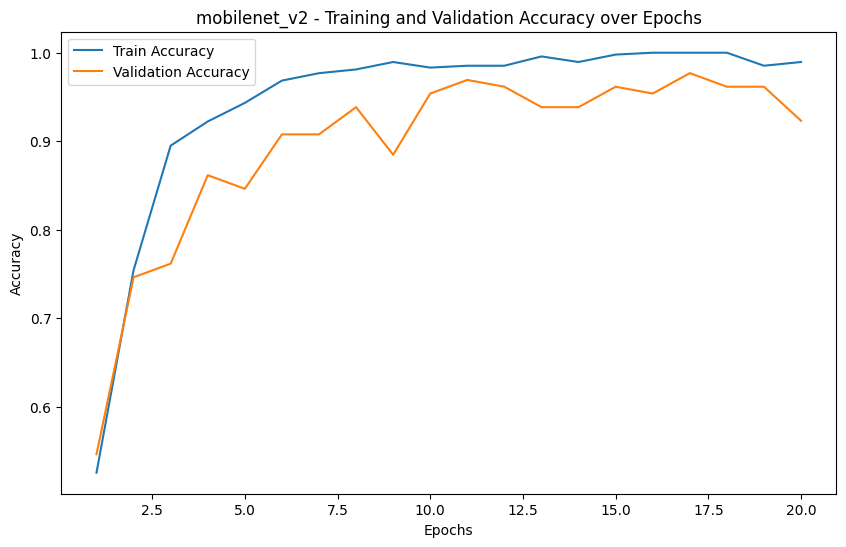

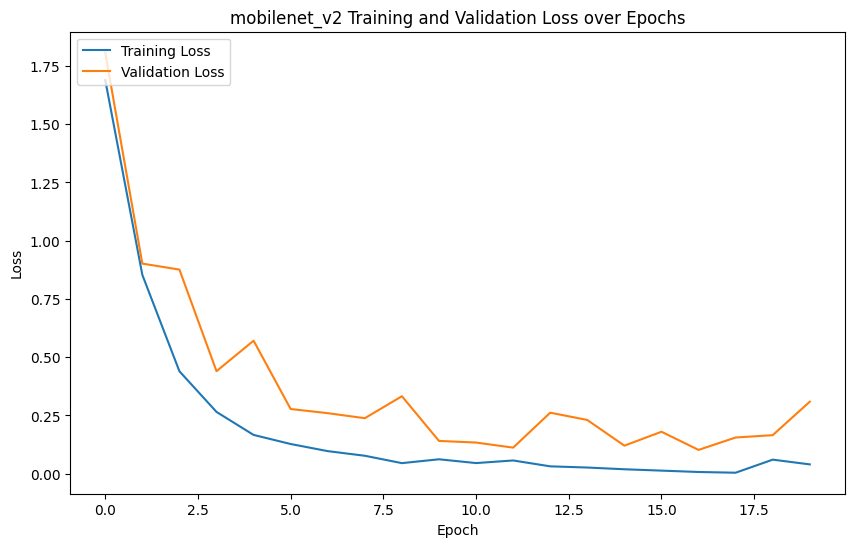

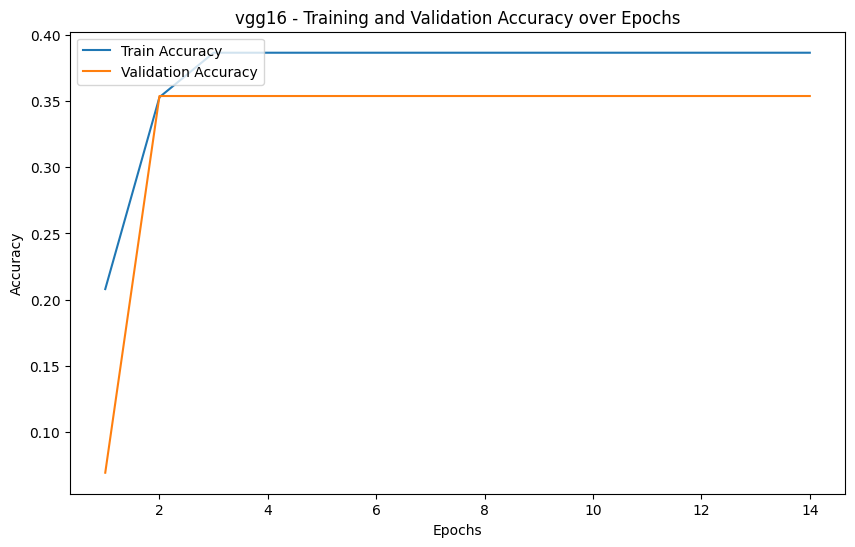

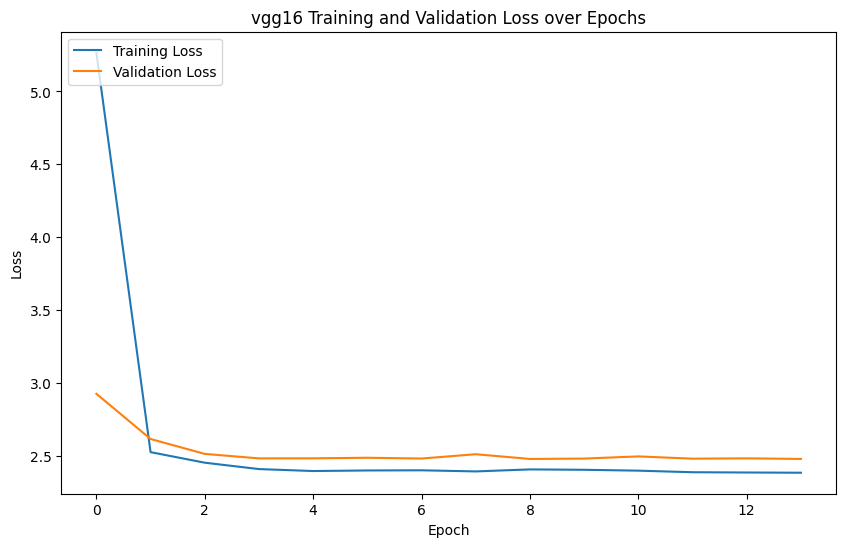

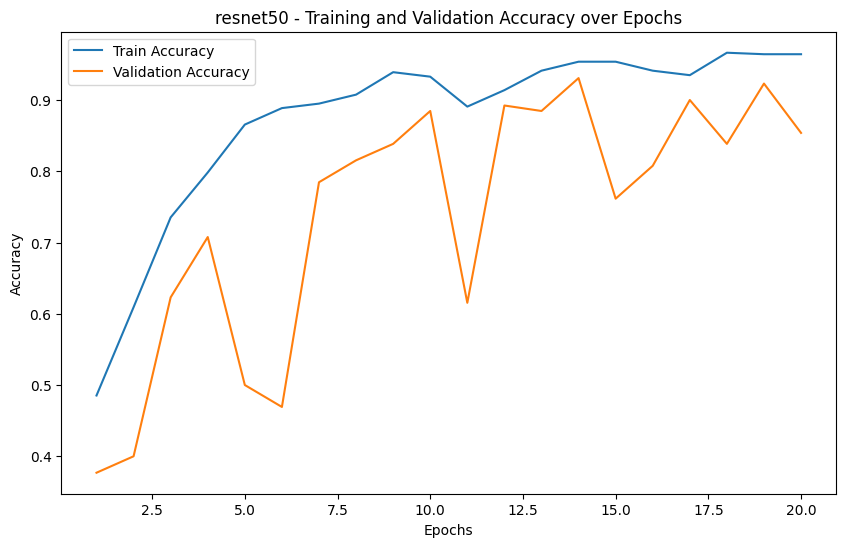

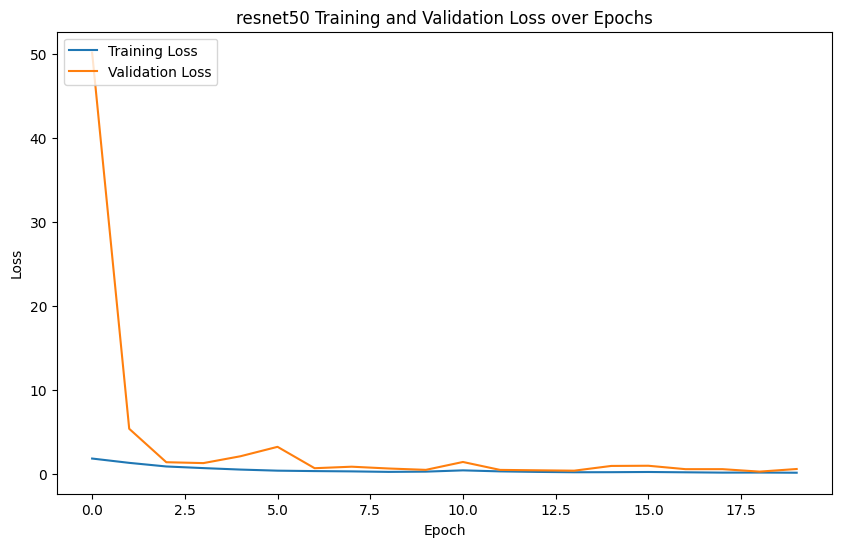

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for model_name in model_names:
    print(f"Training {model_name}...")
    
    # Initialize the model
    # Initialize the model
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the last layer for ResNet50
    elif model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the last layer for VGG16
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Adjust the last layer for MobileNetV2
    else:
        raise ValueError(f"Invalid model name: {model_name}")

        
    num_classes = len(train_dataset.classes)

    
    # Move model to the device
    model = model.to(device)
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)
    
    # Training Loop with early stopping
    num_epochs = 20
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        val_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
         # Calculate Training Accuracy
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        train_accuracies.append(epoch_train_acc.cpu().detach().numpy())
        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
            
        # Calculate validation loss and early stopping
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
        epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
        val_accuracies.append(epoch_val_acc.cpu().detach().numpy())
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        val_loss = val_loss / len(val_loader.dataset)
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')

    plt.title(f'{model_name} - Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
        
    # Save the plot as an image file before showing it
    plt.savefig(f"{model_name}_accuracy_plot.png")
       
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training and Validation Loss over Epochs')
    plt.legend(loc='upper left')
    plt.savefig(f"{model_name}_loss_plot.png")
    
    torch.save(model,f"{model_name}.pkl")
    
    print(f"Finished Training {model_name}")


* Observation:
    1. Mobilenet_v2 is better compared other 2 models in terms of accuracy. But it seems they is a overfitting in Mobilenet_v2 compared with resnet50 

## Custom Model 2

In [20]:
class CustomFaceModel_v2(nn.Module):
    def __init__(self, num_classes):
        super(CustomFaceModel_v2, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Reduced number of filters
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output Size: 112x112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Reduced number of filters
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output Size: 56x56
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Kept same, can be reduced if needed
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output Size: 28x28
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Kept same, can be reduced if needed
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output Size: 14x14
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 14 * 14, 1024),  # Reduced number of neurons and adjusted input size
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),  # Reduced number of neurons
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


Added dropout layer to prevent overfitting

In [25]:
torch.cuda.empty_cache()

training with  param for CustomeModel_v2 0.001 - 32
Epoch 1/20, Train Acc: 0.2227, Val Acc: 0.3615
Validation loss decreased (inf --> 4626.569781). Saving model ...
Epoch 2/20, Train Acc: 0.3866, Val Acc: 0.3923
Validation loss decreased (4626.569781 --> 1212.407321). Saving model ...
Epoch 3/20, Train Acc: 0.4370, Val Acc: 0.4231
Validation loss decreased (1212.407321 --> 971.998757). Saving model ...
Epoch 4/20, Train Acc: 0.4706, Val Acc: 0.4846
Validation loss decreased (971.998757 --> 879.412136). Saving model ...
Epoch 5/20, Train Acc: 0.4748, Val Acc: 0.5615
Validation loss decreased (879.412136 --> 864.821662). Saving model ...
Epoch 6/20, Train Acc: 0.4769, Val Acc: 0.4769
Validation loss decreased (864.821662 --> 862.763770). Saving model ...
Epoch 7/20, Train Acc: 0.5105, Val Acc: 0.5077
Validation loss decreased (862.763770 --> 803.297061). Saving model ...
Epoch 8/20, Train Acc: 0.5483, Val Acc: 0.5308
Validation loss decreased (803.297061 --> 751.130698). Saving model ...

RuntimeError: File checkpoint.pt cannot be opened.

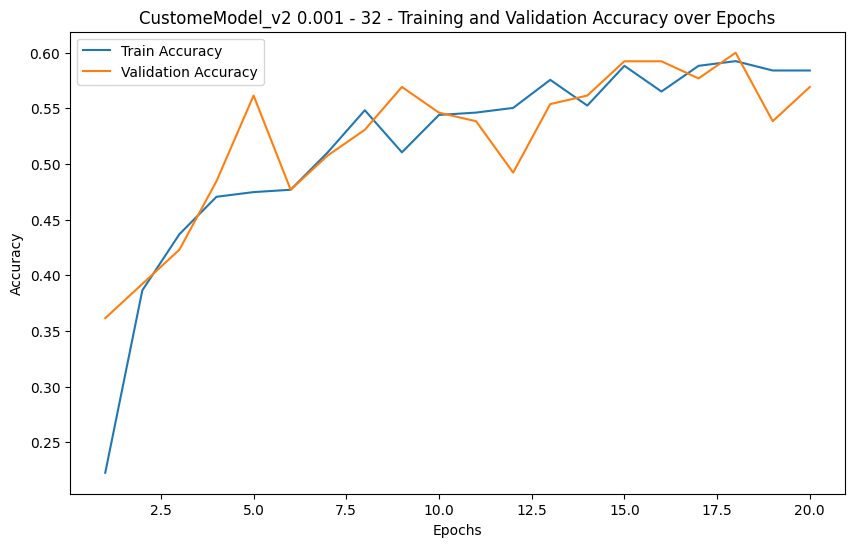

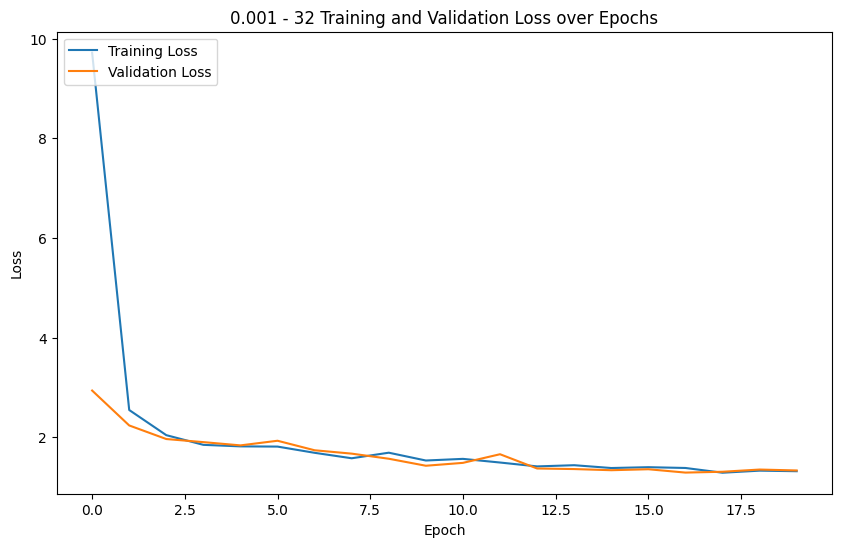

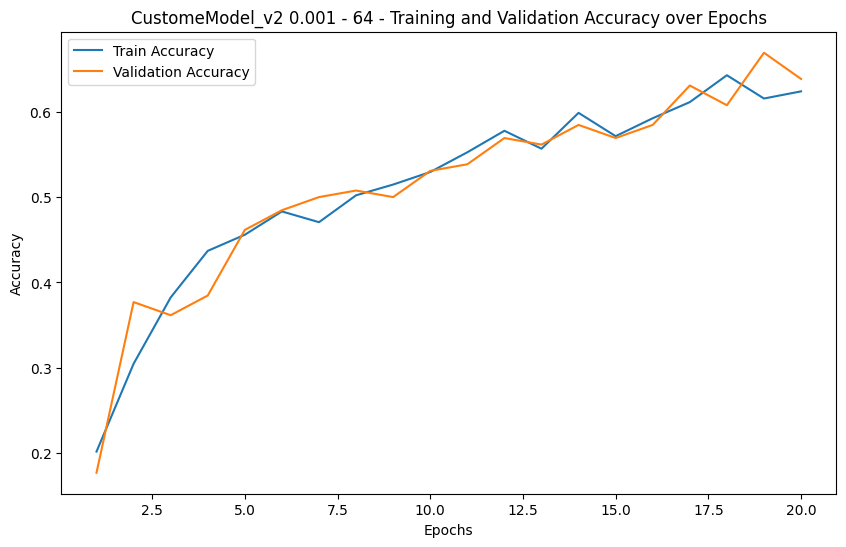

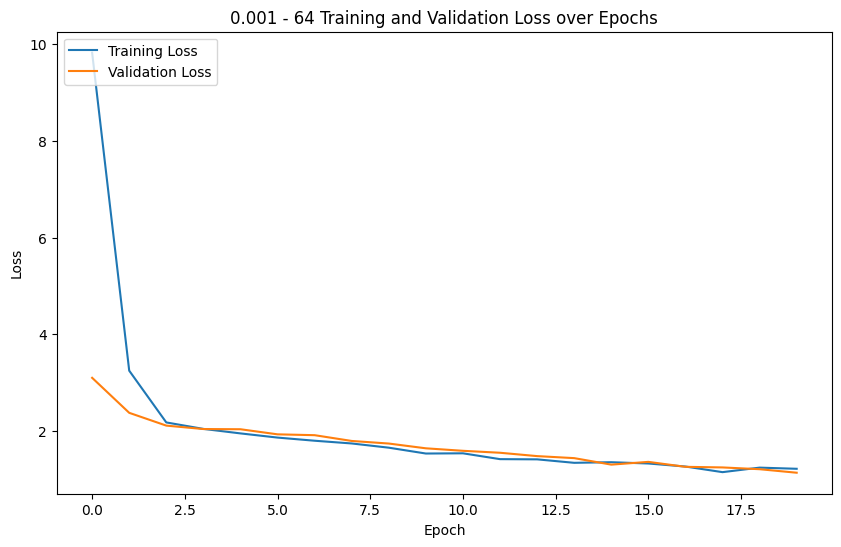

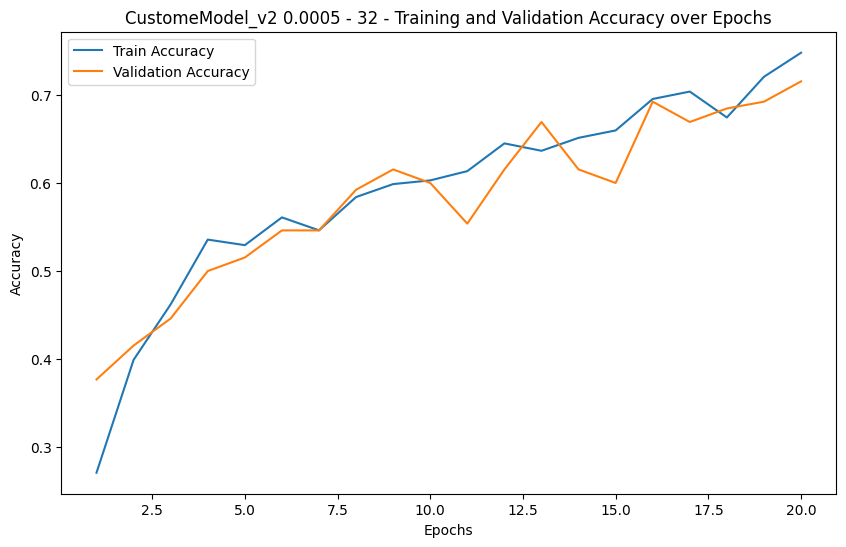

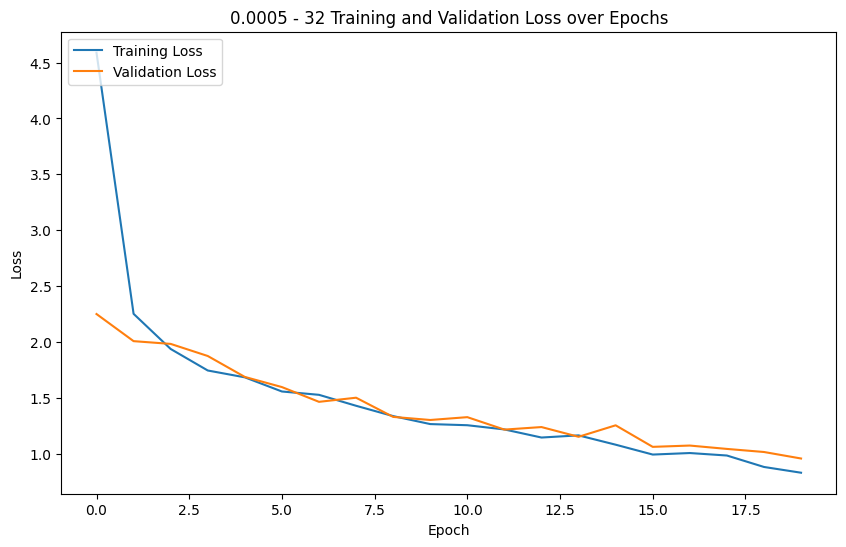

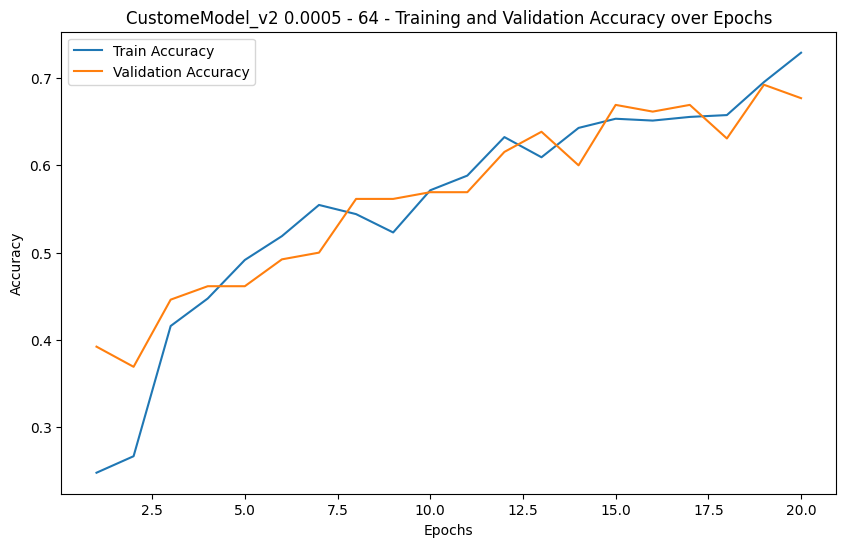

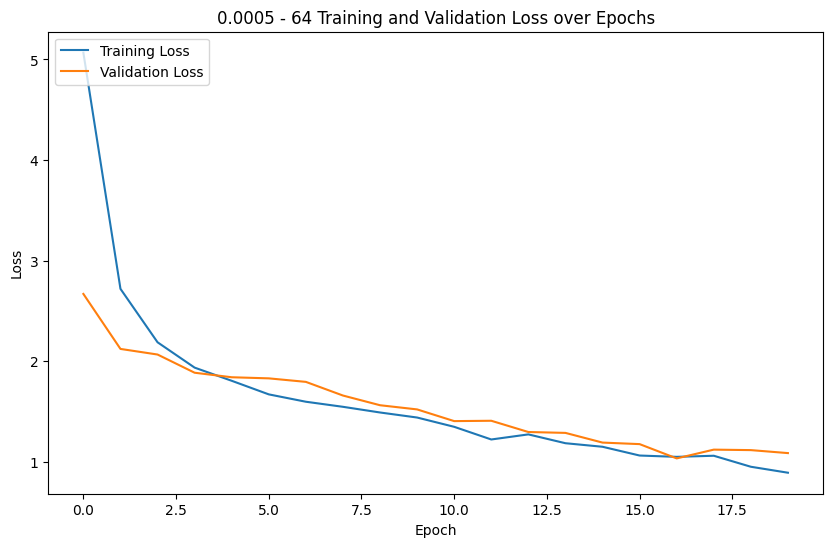

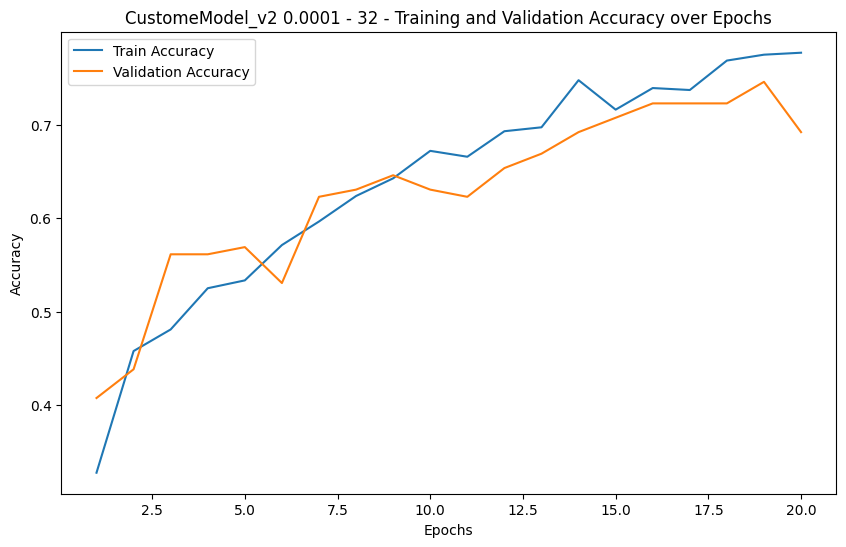

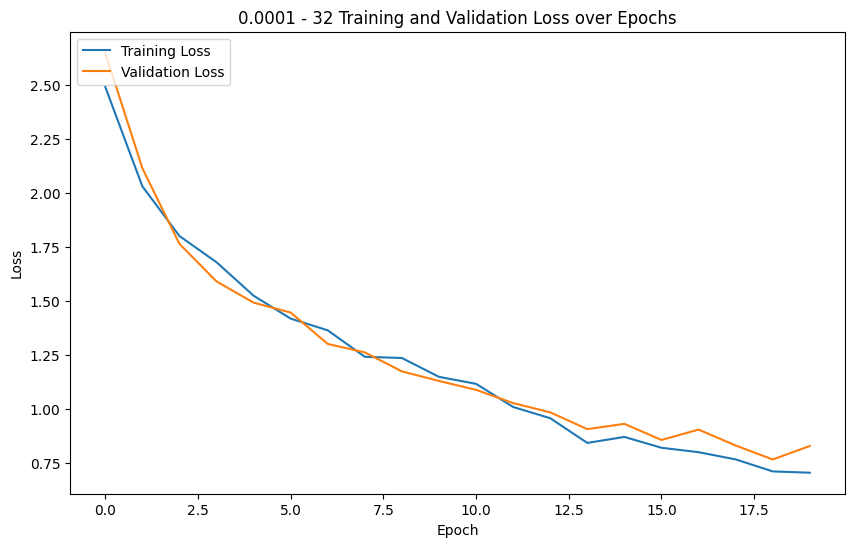

In [26]:
# Define hyperparameter search space
learning_rates = [0.001,0.0005,0.0001]
batch_sizes = [32,64]
train_accuracies = []
val_accuracies = []
num_classes = 20
num_epochs = 20
# Hyperparameter tuning loop
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"training with  param for CustomeModel_v2 {lr} - {bs}")
        # Initialize model, criterion, optimizer, and early stopping
        model = CustomFaceModel_v2(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        early_stopping = EarlyStopping(patience=5, verbose=True)
        
        # Update DataLoader with new batch size
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        
        # Training loop with early stopping
        # Lists to store accuracies
        train_accuracies = []
        val_accuracies = []
        train_losses = []
        val_losses = []
        
        # Training Loop with early stopping
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            running_corrects = 0
            val_loss = 0.0
            val_corrects = 0
            # Training Step
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)
            
            # Calculate Training Accuracy
            epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
            train_accuracies.append(epoch_train_acc.cpu().detach().numpy())
            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)
            
            # Validation Step
            model.eval()
            val_corrects = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    val_corrects += torch.sum(preds == labels.data)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
            # Calculate Validation Accuracy
            epoch_val_acc = val_corrects.double() / len(val_loader.dataset)
            val_accuracies.append(epoch_val_acc.cpu().detach().numpy())
            
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            
            print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")
            
            # Early Stopping
            early_stopping(running_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        
        torch.save(model,f"CustomeFaceModel_v2 {lr} - {bs}.pkl")
        
        plt.figure(figsize=(10,6))
        plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')

        plt.title(f'CustomeModel_v2 {lr} - {bs} - Training and Validation Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
            
        # Save the plot as an image file before showing it
        plt.savefig(f" CustomeModel_v2{lr} - {bs}_accuracy_plot.png")
        
        plt.figure(figsize=(10,6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{lr} - {bs} Training and Validation Loss over Epochs')
        plt.legend(loc='upper left')
        plt.savefig(f"CustomeModel_v2 {lr} - {bs}_loss_plot.png")

* Observation:
    1. Overfitting is prevented but accuracy is bad in comparision with CustomeModel